In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from mnist_model import generator,discriminator
import utils
l = tf.layers

## Hyperparam

In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 2,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4,
    logdir = 'gan_mnist/',
    name_model = 'model_latent2_FC'
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation (unl)

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
trainx_unl = trainx.copy()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build model

In [4]:
tf.reset_default_graph()

In [5]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [6]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net
# samples = generator(noise,is_training_pl,reuse=False)
# real_score = discriminator(data,is_training_pl,reuse=False)
# fake_score = discriminator(samples,is_training_pl,reuse=True)

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

Tensor("discriminator/layer_3/leaky_relu/sub:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator_1/layer_3/leaky_relu/sub:0", shape=(100, 4, 4, 512), dtype=float32)


In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [8]:
if tf.train.latest_checkpoint(os.path.join('./saved_models/',params['logdir'])) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(os.path.join('./saved_models/',params['logdir'])))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./saved_models/gan_mnist/model_latent2_FC


HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

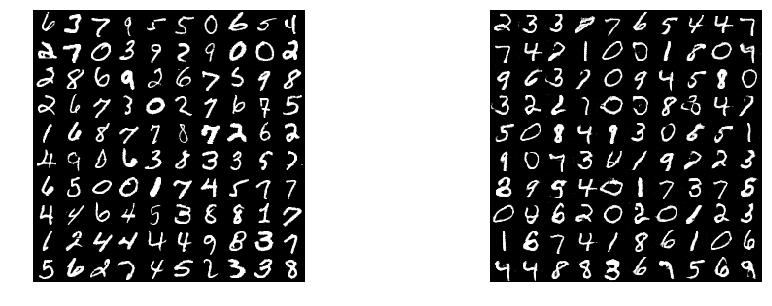

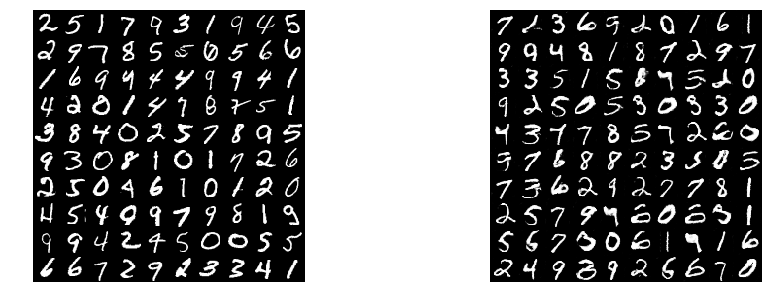

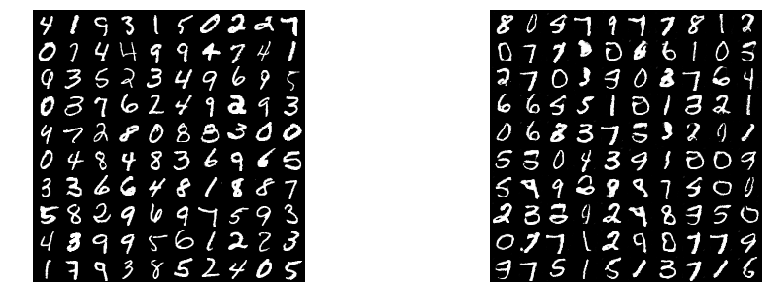

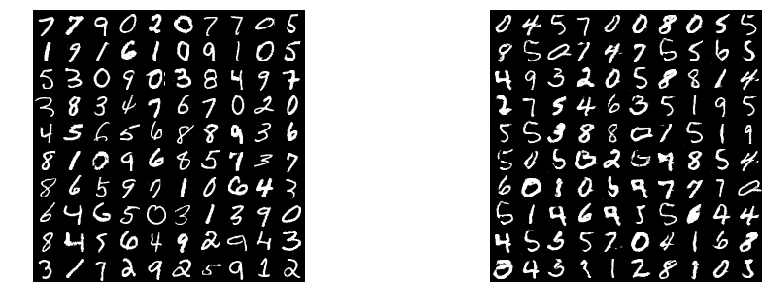

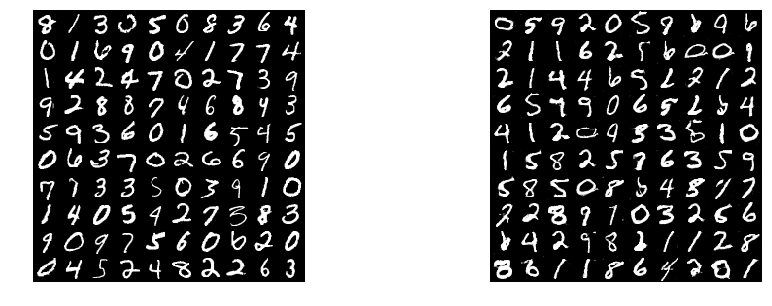

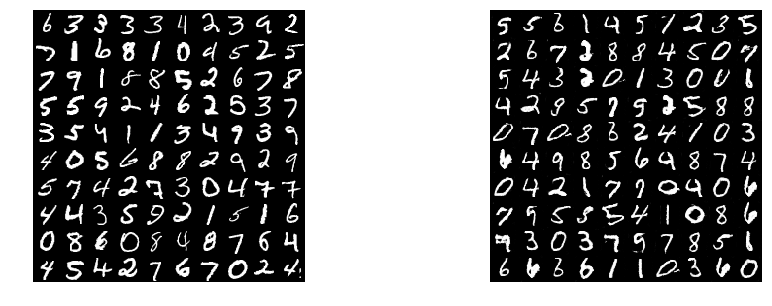

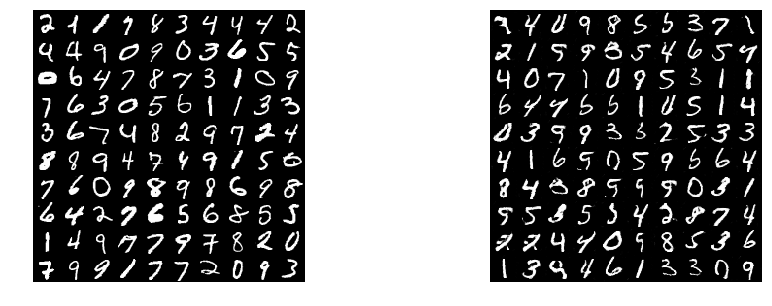

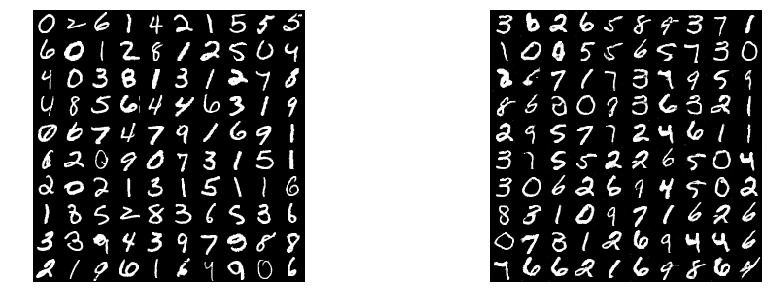

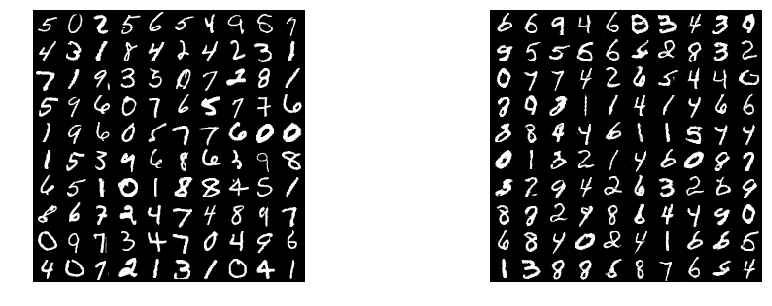

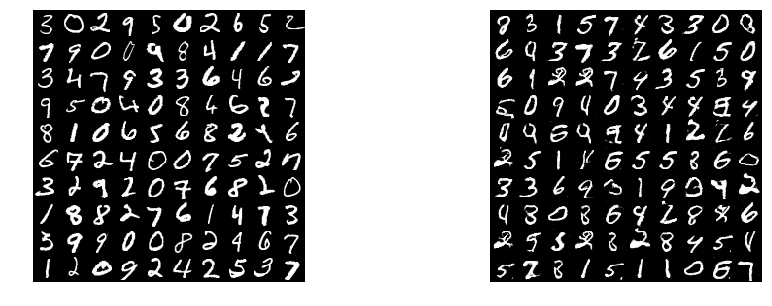

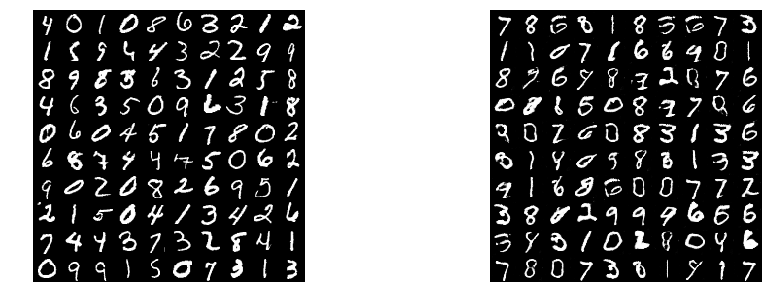

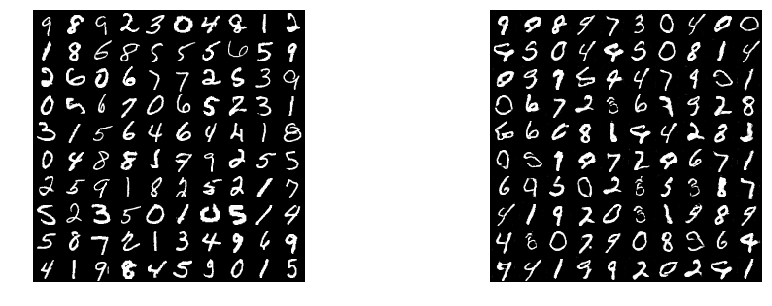

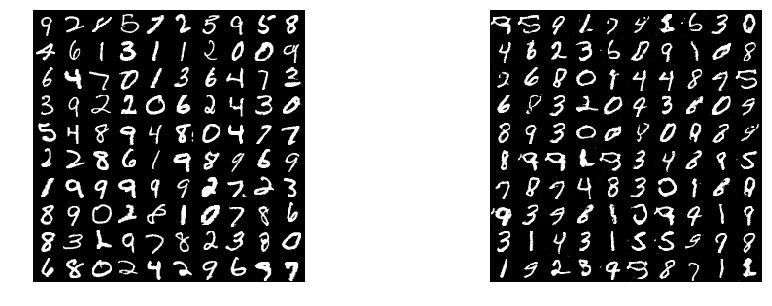

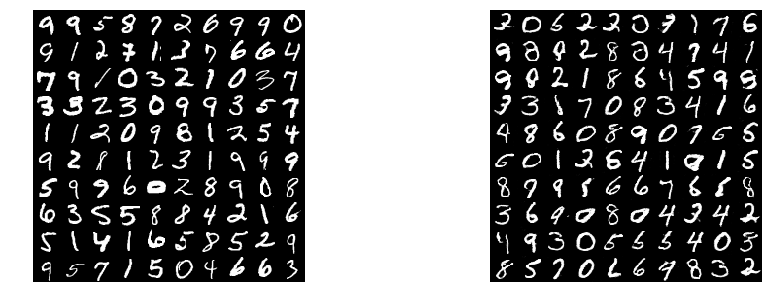

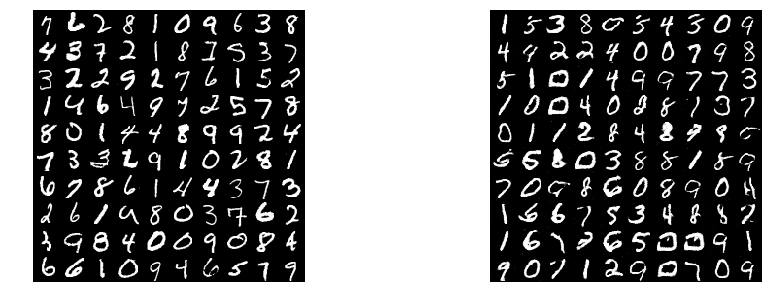

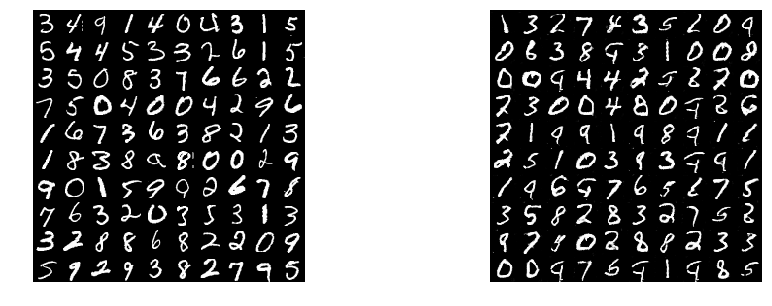

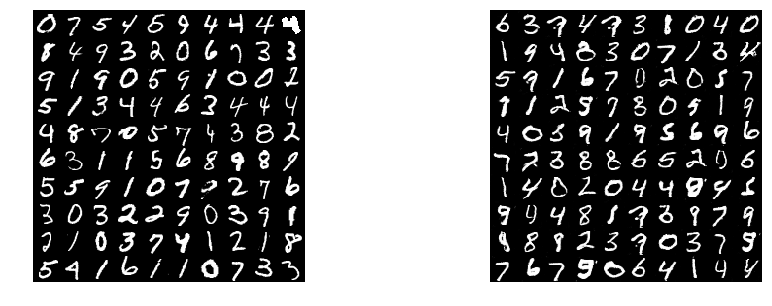

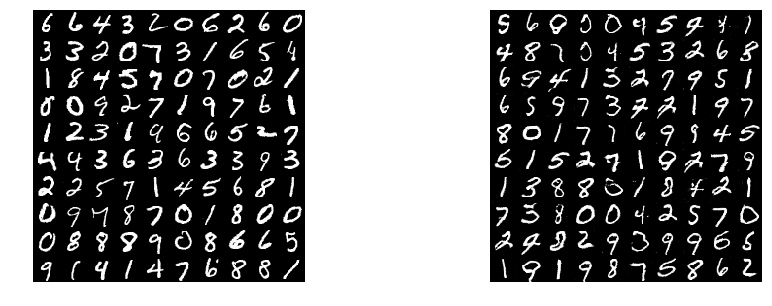

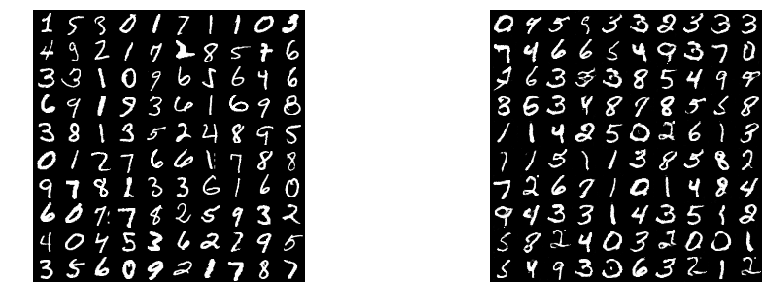

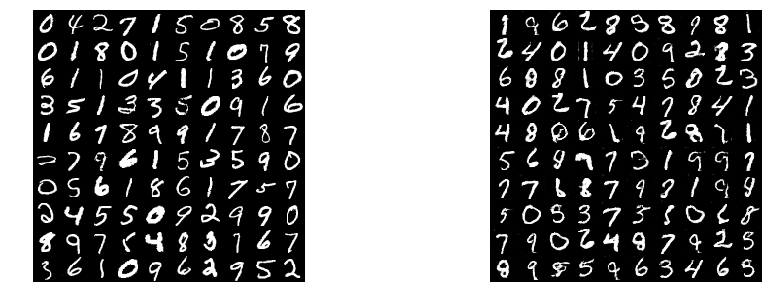

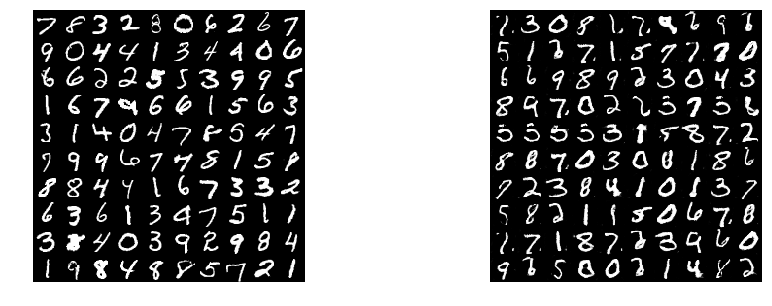

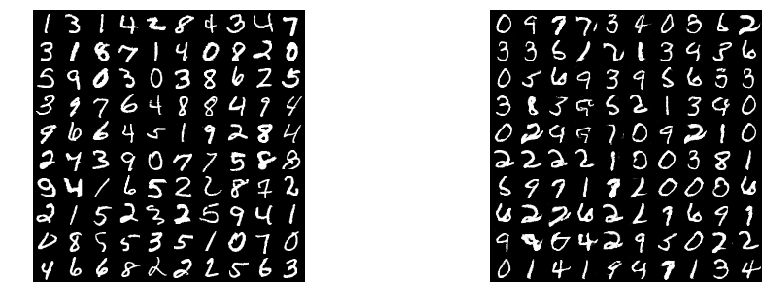

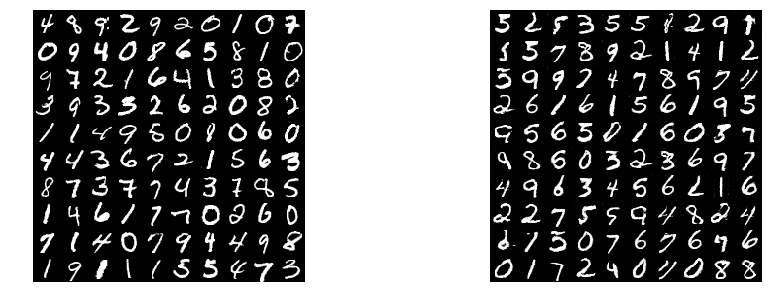

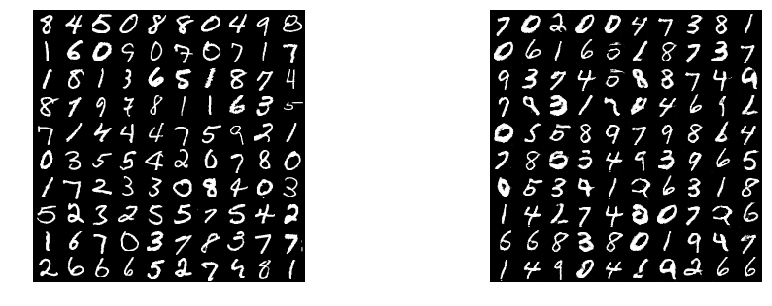

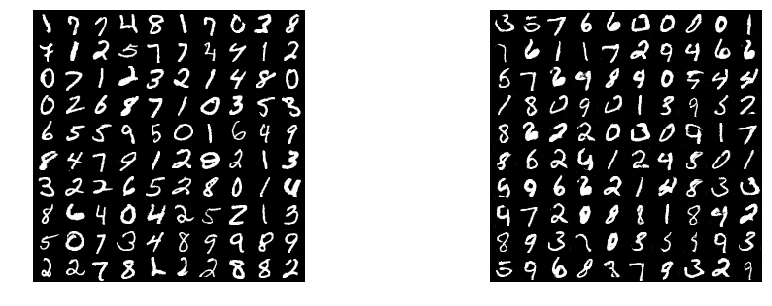

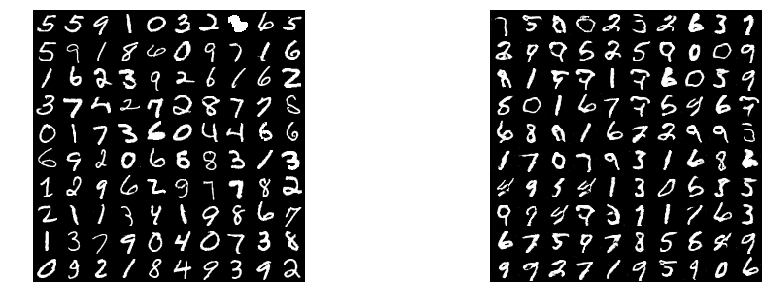

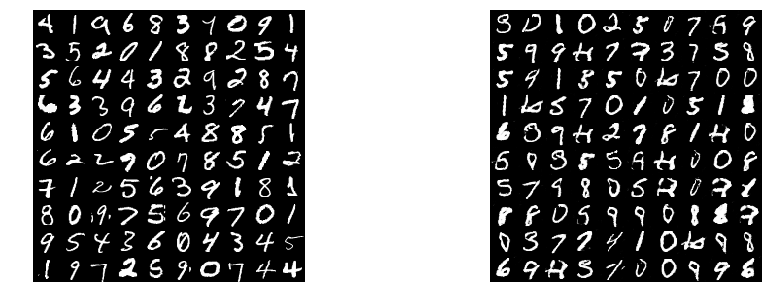

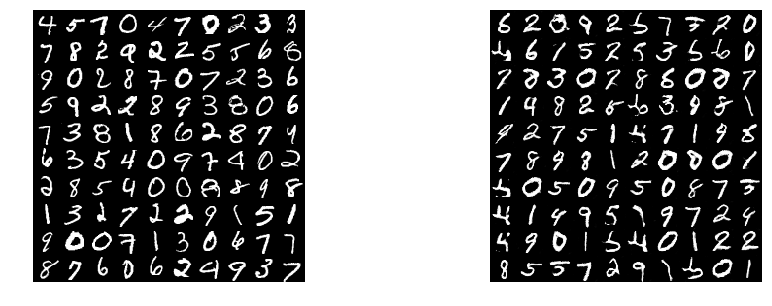

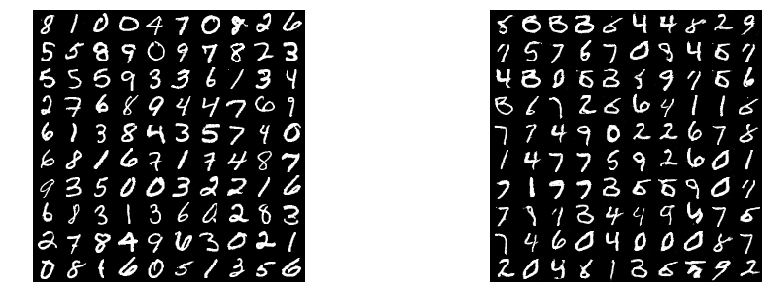

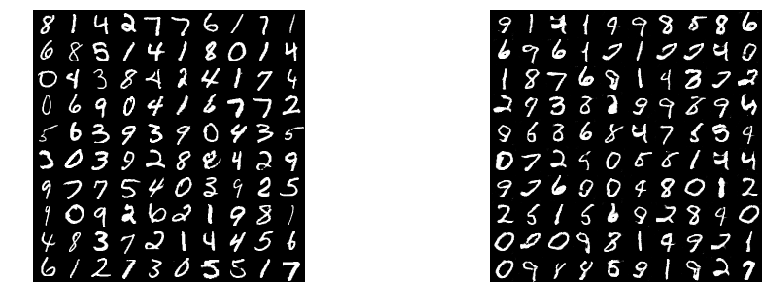

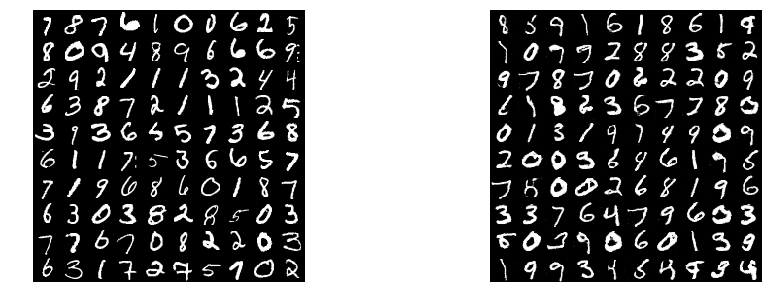

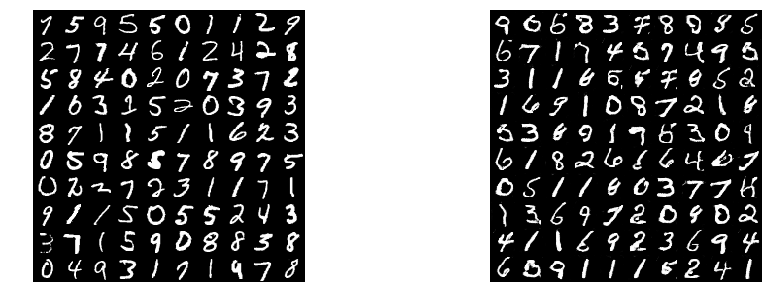

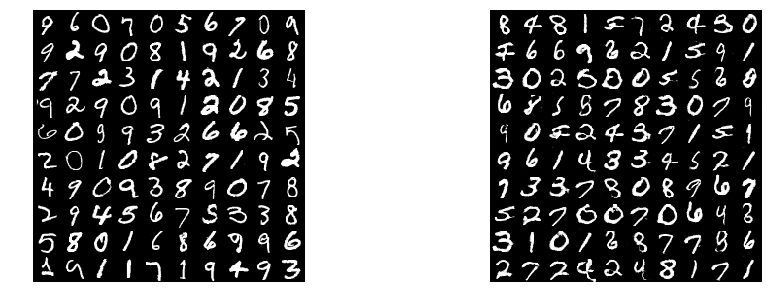

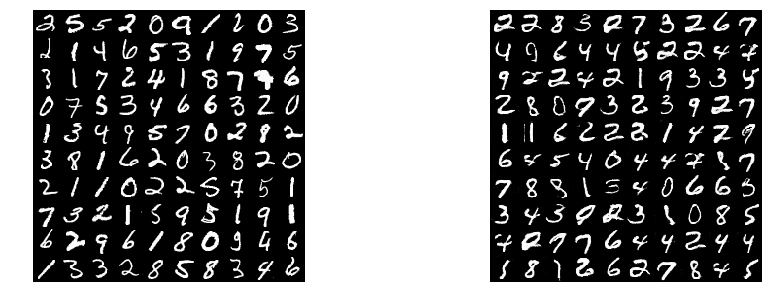

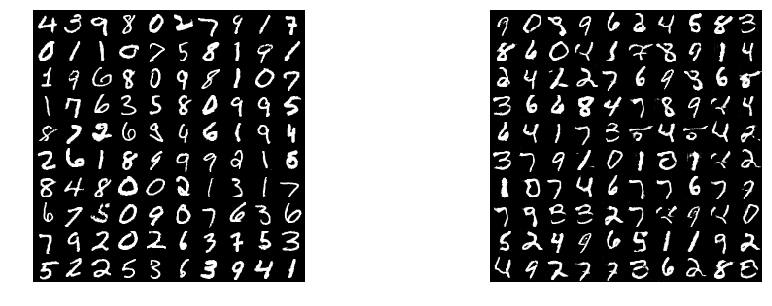

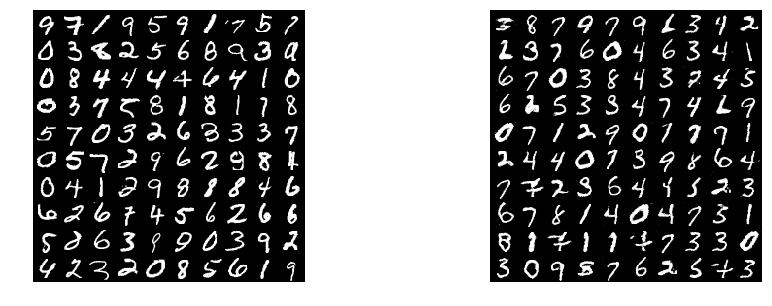

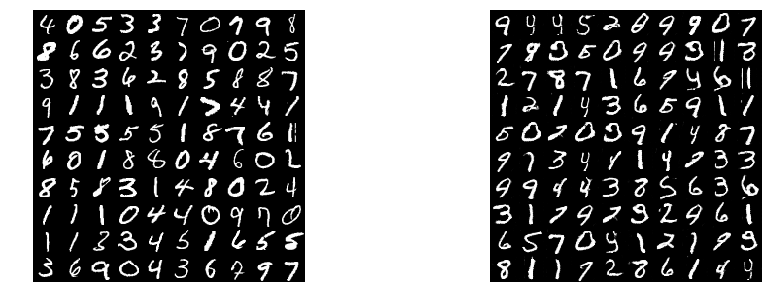

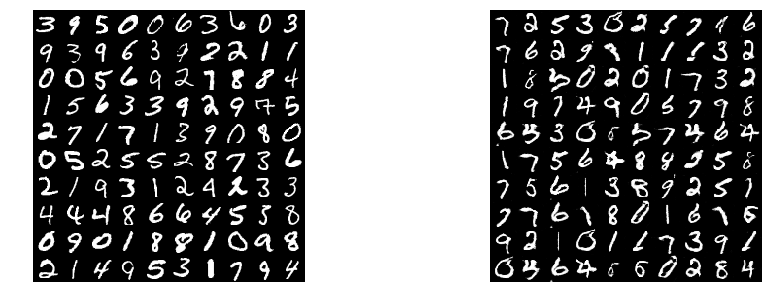

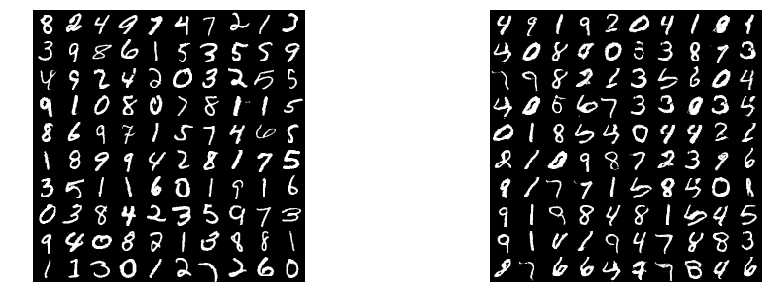

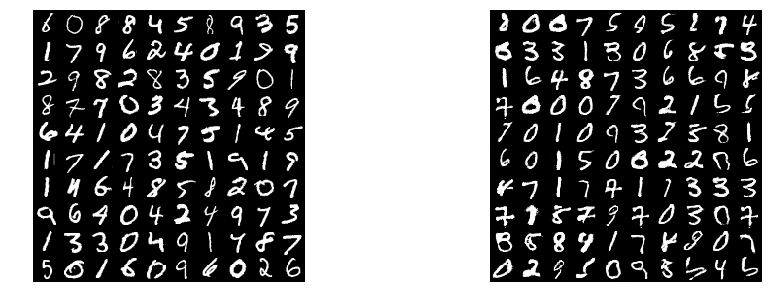

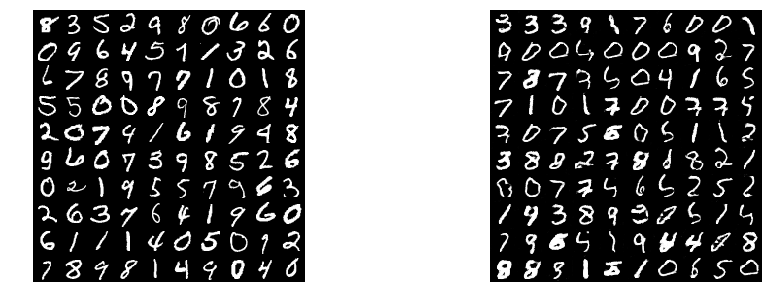

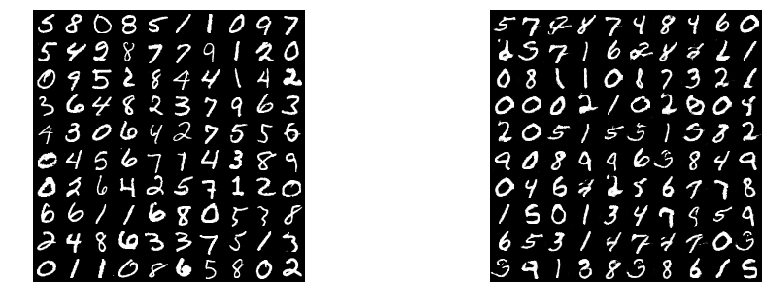

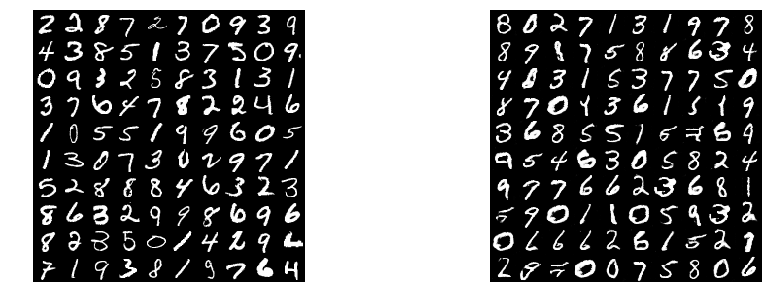

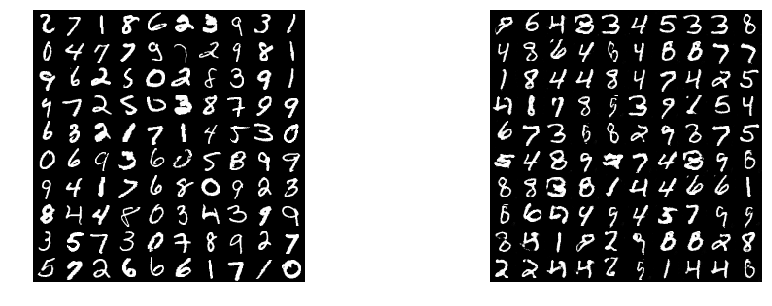

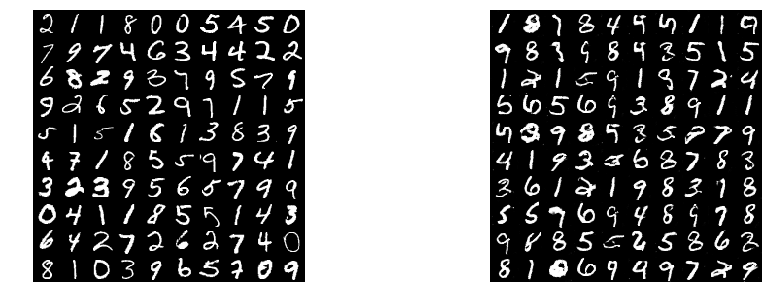

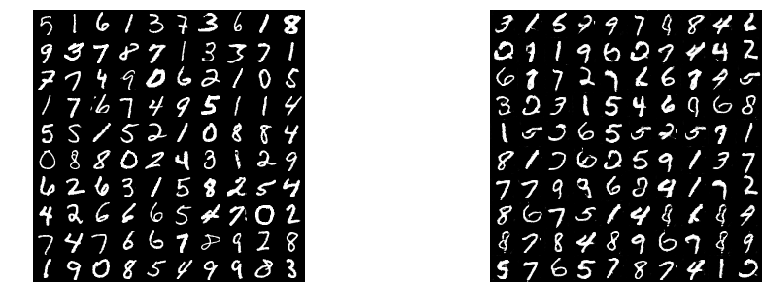

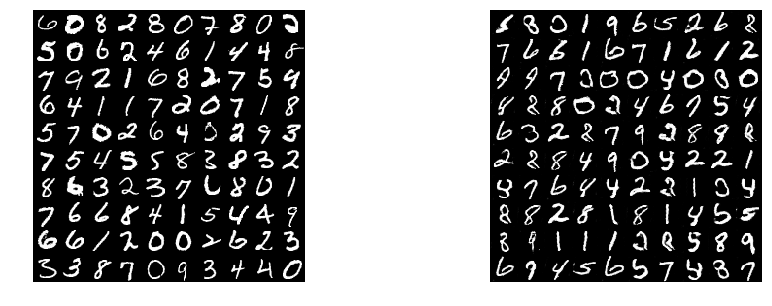

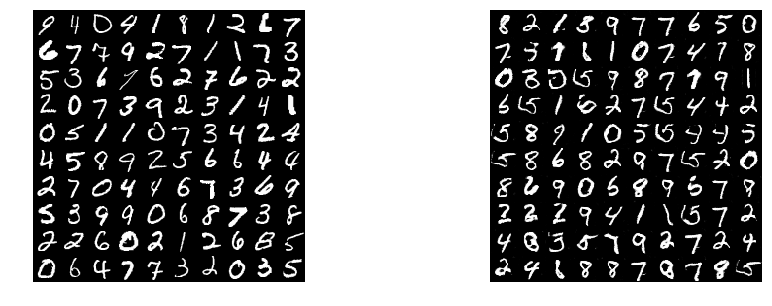

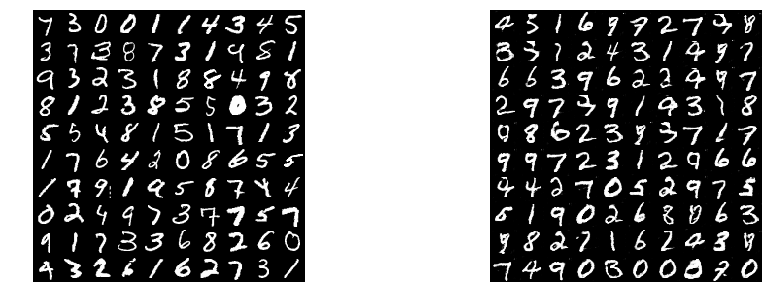

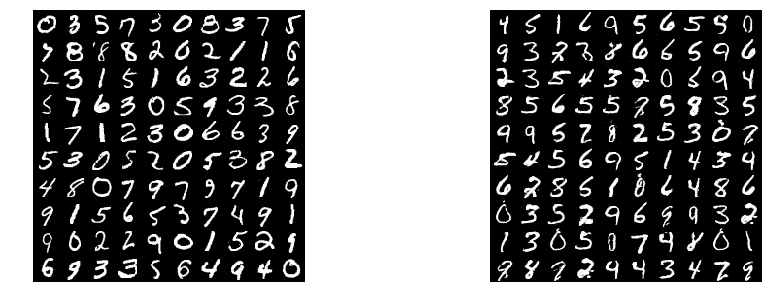

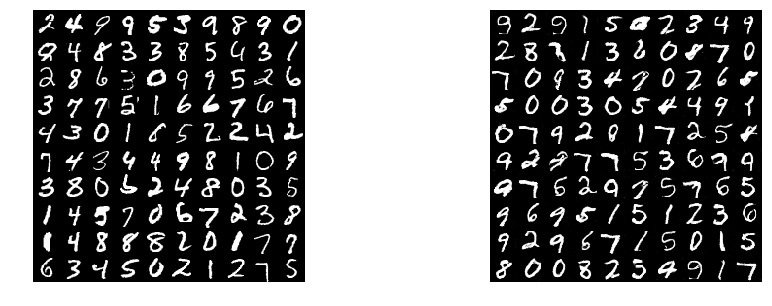

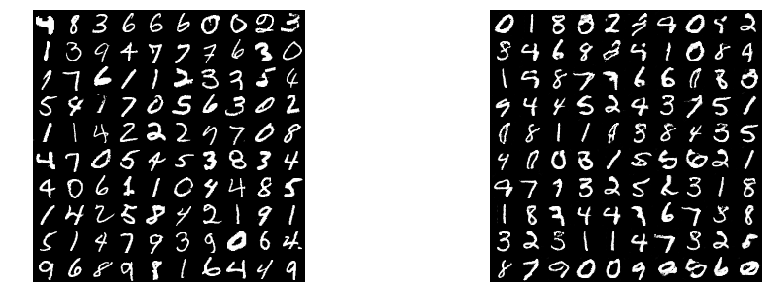

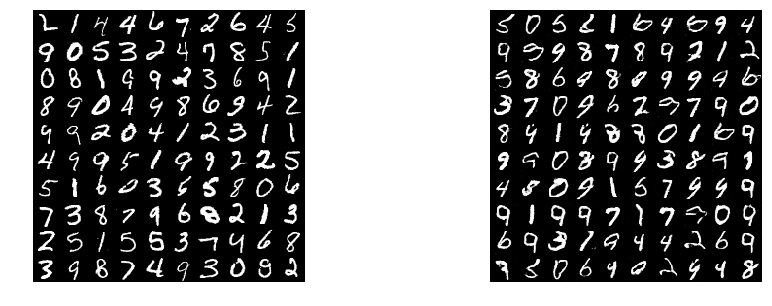

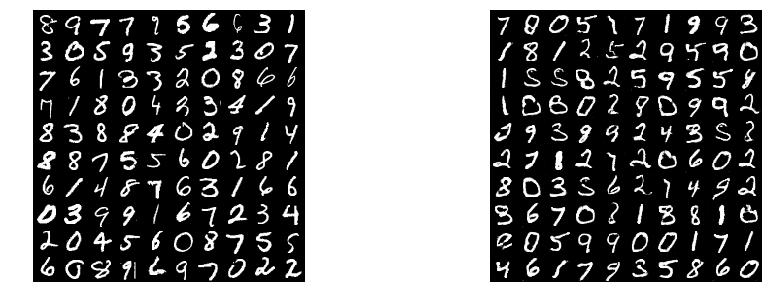

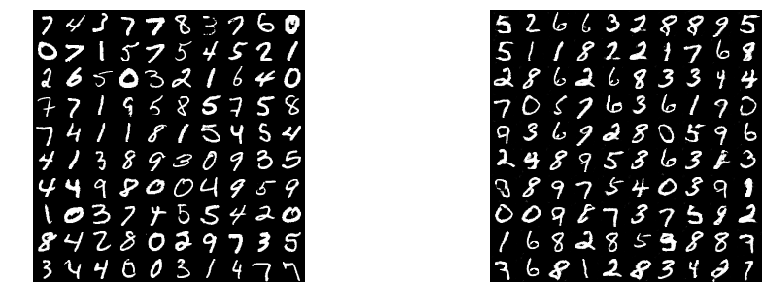

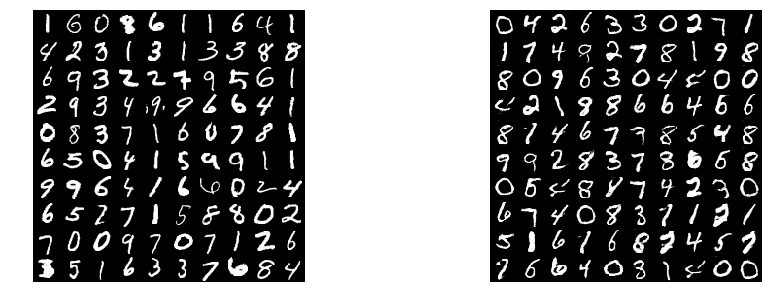

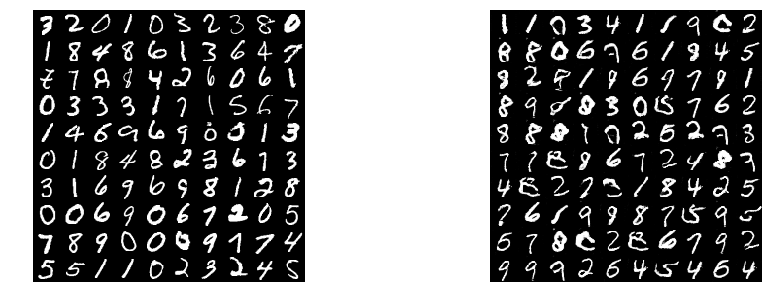

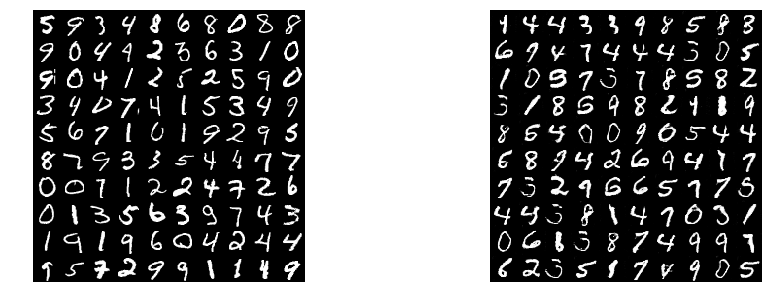

KeyboardInterrupt: 

In [9]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 100
lsd=[]
lsg=[]
for i in tqdm(range(20000)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    ld,_=sess.run([loss_d,traind],{is_training_pl:True})
    lg,_=sess.run([loss_g, traing],{is_training_pl:True})
    lsd.append(ld); lsg.append(lg);

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:True})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()


In [52]:

if not os.path.exists(params['logdir']):
    os.makedirs(params['logdir'])
saver.save(sess, os.path.join('./saved_models/',params['logdir'],params['name_model']))

'./saved_models/gan_mnist/model_latent2_FC'

## Hyper param perturbation DNN

In [5]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.1, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=1e-3,
    beta1 = 0.9,
    epoch = 8000,
    l2_w = 0.1,
    labeled = 10000
)
rng = np.random.RandomState(params['seed'])  # seed labels

# labeled data

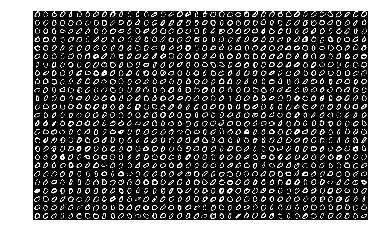

In [6]:
labeled = params_dnn['labeled']
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:1000])
plt.show()

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params_dnn['batch'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params_dnn['batch'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
next_label = tf.cast(next_label,tf.int64)

train_trigger = iterator.make_initializer(train_dataset)
test_trigger = iterator.make_initializer(test_dataset)

## Vizualizing perturbation

In [ ]:
z = tf.random_normal(shape=[params_dnn['mc'],params['z_dim']]) # samples = generator(noise,is_training_pl,reuse=False)
perturb = tf.random_normal([params_dnn['mc'],params['z_dim']], mean=0, stddev=1)
perturb_n = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = z + params_dnn['delta']* perturb_n
z_pert = z + tf.random_normal([params_dnn['mc'],params['z_dim']], mean=0, stddev=0.1)

samp_pert = generator(z_pert,is_training_pl,reuse=True)
samp = generator(z,is_training_pl,reuse=True)
# samp_adv = samp + params_dnn['epsilon']* tf.nn.l2_normalize(samp_pert-samp,dim=[1])
samp_adv = samp_pert

# f_samp_adv = soft(lenet(samp_adv,training_cnn))
f_samp = soft(lenet(samp,training_cnn))
# tan_consistency = tf.sqrt(1e-8 + tf.pow(f_samp_adv-f_samp,2))
# tan_loss = tf.reduce_mean(tan_consistency)

# _nabla = tf.gradients(tan_consistency, perturb)[0]

In [37]:
z = tf.random_normal(shape=[params_dnn['mc'],params['z_dim']]) # samples = generator(noise,is_training_pl,reuse=False)
samp = generator(z,is_training_pl,reuse=True)
f_samp = soft(lenet(samp,training_cnn))
jac = utils.get_jacobian(f_samp,z)
jac_norm = tf.sqrt(1e-8+tf.reduce_sum(tf.sqrt(jac),axis=[1,2]))
jac_loss = tf.reduce_mean(jac_norm)

In [38]:
print(jac)

Tensor("jacob/stack:0", shape=(200, 2, 10), dtype=float32)


In [40]:
jac_norm = tf.sqrt(1e-8+tf.reduce_sum(tf.sqrt(jac),axis=[1,2]))
print(jac_norm)
jac_loss = tf.reduce_mean(jac_norm)

Tensor("Sqrt_3:0", shape=(200,), dtype=float32)


In [25]:
z = tf.random_normal(shape=[params_dnn['mc'],params['z_dim']]) # samples = generator(noise,is_training_pl,reuse=False)
perturb = tf.random_normal([params_dnn['mc'],params['z_dim']], mean=0, stddev=1)
perturb_n = tf.nn.l2_normalize(perturb, dim=[1])
z_pert = z + 10* perturb_n
samp = generator(z,is_training_pl,reuse=True)
samp_pert = generator(z_pert,is_training_pl,reuse=True)


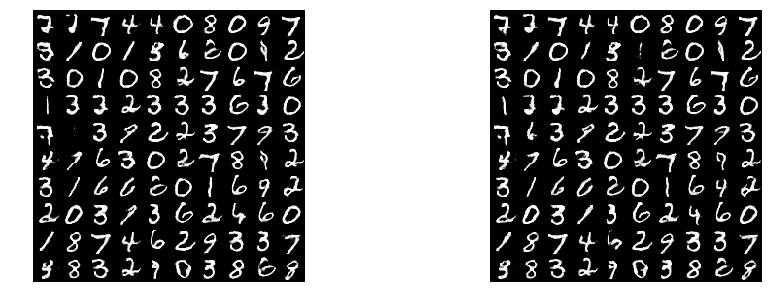

In [21]:
xx,yy = sess.run([samp,samp_pert],{is_training_pl:False})

plt.figure(figsize=(15,5))
plt.subplot(121)
show_digits(xx[:100])
plt.subplot(122)
show_digits(yy[:100])
plt.show()

# plt.show()


In [26]:
def kl_divergence_with_logit(q_logit, p_logit):
    q = tf.nn.softmax(q_logit)
    qlogq = tf.reduce_mean(tf.reduce_sum(q * logsoftmax(q_logit), 1))
    qlogp = tf.reduce_mean(tf.reduce_sum(q * logsoftmax(p_logit), 1))
    return qlogq - qlogp

In [27]:
kl = kl_divergence_with_logit(samp,samp_pert)

In [42]:
tf.reset_default_graph()

## defining model

In [8]:
def lenet(x,training_pl):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x
    
soft = lambda x: 1/(1+tf.exp(-x))    

In [9]:
training_cnn  = tf.placeholder(tf.bool,[])
logits = lenet(next_element,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=next_label)

# z = tf.random_normal(shape=[params_dnn['mc'],params['z_dim']]) # samples = generator(noise,is_training_pl,reuse=False)
# samp = generator(z,is_training_pl,reuse=True)
# f_samp = soft(lenet(samp,training_cnn))
# jac = utils.get_jacobian(f_samp,z)
# jac_norm = tf.sqrt(1e-8+tf.reduce_sum(tf.sqrt(jac),axis=[1,2]))
# jac_loss = tf.reduce_mean(jac_norm)

# loss = xloss + 0.1 * jac_loss
loss = xloss

In [11]:
with tf.variable_scope("classifier",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    train_op = optimizer.minimize(xloss,var_list=tf.trainable_variables(scope='classifier'))

correct_prediction = tf.equal(tf.argmax(logits,1),next_label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#init
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

## cnn training

In [16]:
sess.run([train_trigger,init_op])
for i in tqdm(range(params_dnn['epoch']+1)):
#     xl,_,acc = sess.run([xloss,train_op,accuracy],feed_dict={training_cnn:True,is_training_pl:False})
    xl,_,acc = sess.run([xloss,train_op,accuracy],feed_dict={training_cnn:True})

    if i % 100 == 0:
        sess.run(test_trigger)
        test_acc = 0
        for n in range(nr_batch_test):
            test_acc  += sess.run(accuracy,feed_dict={training_cnn:False})# ,is_training_pl:False
        test_acc /= nr_batch_test
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(i, xl, acc * 100,test_acc*100))
        sess.run(train_trigger)

HBox(children=(IntProgress(value=0, max=8001), HTML(value='')))

Step: 0, xloss: 2.32787, training acc: 2.00%, test acc: 9.20%
Step: 100, xloss: 0.00896, training acc: 100.00%, test acc: 30.30%
Step: 200, xloss: 0.00531, training acc: 100.00%, test acc: 30.96%
Step: 300, xloss: 0.00262, training acc: 100.00%, test acc: 30.96%
Step: 400, xloss: 0.01575, training acc: 100.00%, test acc: 31.04%
Step: 500, xloss: 0.00338, training acc: 100.00%, test acc: 30.74%
Step: 600, xloss: 0.01278, training acc: 100.00%, test acc: 31.06%
Step: 700, xloss: 0.00039, training acc: 100.00%, test acc: 31.12%
Step: 800, xloss: 0.00093, training acc: 100.00%, test acc: 31.12%
Step: 900, xloss: 0.00052, training acc: 100.00%, test acc: 31.04%
Step: 1000, xloss: 0.00943, training acc: 100.00%, test acc: 31.12%
Step: 1100, xloss: 0.00196, training acc: 100.00%, test acc: 31.06%
Step: 1200, xloss: 0.00034, training acc: 100.00%, test acc: 30.94%



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/bruno/.local/lib/python3.5/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Step: 1300, xloss: 0.01325, training acc: 100.00%, test acc: 31.02%
Step: 1400, xloss: 0.00014, training acc: 100.00%, test acc: 31.16%
Step: 1500, xloss: 0.00805, training acc: 100.00%, test acc: 30.98%
Step: 1600, xloss: 0.00073, training acc: 100.00%, test acc: 31.06%
Step: 1700, xloss: 0.00002, training acc: 100.00%, test acc: 31.18%
Step: 1800, xloss: 0.00166, training acc: 100.00%, test acc: 30.94%
Step: 1900, xloss: 0.00872, training acc: 100.00%, test acc: 31.14%
Step: 2000, xloss: 0.14753, training acc: 96.00%, test acc: 31.04%
Step: 2100, xloss: 0.00164, training acc: 100.00%, test acc: 31.16%
Step: 2200, xloss: 0.00001, training acc: 100.00%, test acc: 31.16%
Step: 2300, xloss: 0.00001, training acc: 100.00%, test acc: 31.18%
Step: 2400, xloss: 0.00000, training acc: 100.00%, test acc: 30.88%
Step: 2500, xloss: 0.00091, training acc: 100.00%, test acc: 31.16%
Step: 2600, xloss: 0.00003, training acc: 100.00%, test acc: 31.08%
Step: 2700, xloss: 0.00012, training acc: 100.00%

In [ ]:
# manifold_cnn = manifold
# xentropy_cnn = xentropy
# v_cnn = v
# taccu_cnn = taccu